In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import seaborn as sns
import os

plt.rcParams.update({
    "pdf.fonttype": 42,
    "font.family": "serif",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11
})

sns.set_style("whitegrid")

In [8]:
results_path = Path('results')
compact_table_path_uncivil = results_path / 'compact_result_table_uncivil_without_duplicates.xlsx'
compact_table_path_civil = results_path / 'compact_result_table_civil_without_duplicates.xlsx'

uncivil = pd.read_excel(compact_table_path_uncivil)
uncivil = uncivil.ffill()
uncivil = uncivil.loc[~uncivil['Model'].isin(['toxicr', 'refined_model']).values]
uncivil = uncivil.rename(columns={'precision': 'Precision', 'recall': 'Recall', 'f1-score': 'F1-score'})
uncivil_sem_combinacoes = uncivil.loc[~uncivil['Strategy'].str.contains('role_based_')]  # excluir combinações com role-based

civil = pd.read_excel(compact_table_path_civil)
civil = civil.ffill()
civil = civil.loc[~civil['Model'].isin(['toxicr', 'refined_model']).values]
civil = civil.rename(columns={'precision': 'Precision', 'recall': 'Recall', 'f1-score': 'F1-score'})
civil_sem_combinacoes = civil.loc[~civil['Strategy'].str.contains('role_based_')]  # excluir combinações com role-based

In [13]:
df_long

,Model,Class,Strategy,Metric,Score
0,deepseek-r1_8b,Uncivil,zero_shot,Precision,0.910
1,deepseek-r1_14b,Uncivil,zero_shot,Precision,0.817
2,gemma_7b,Uncivil,zero_shot,Precision,0.439
3,gemma2_9b,Uncivil,zero_shot,Precision,0.644
4,llama3.1_8b,Uncivil,zero_shot,Precision,0.656
...,...,...,...,...,...
475,llama3.2_3b,Civil,role_based_auto_cot,F1-score,0.798
476,mistral_7b,Civil,role_based_auto_cot,F1-score,0.861
477,mistral-nemo_12b,Civil,role_based_auto_cot,F1-score,0.827
478,phi4_14b,Civil,role_based_auto_cot,F1-score,0.864


<Figure size 1500x1500 with 0 Axes>

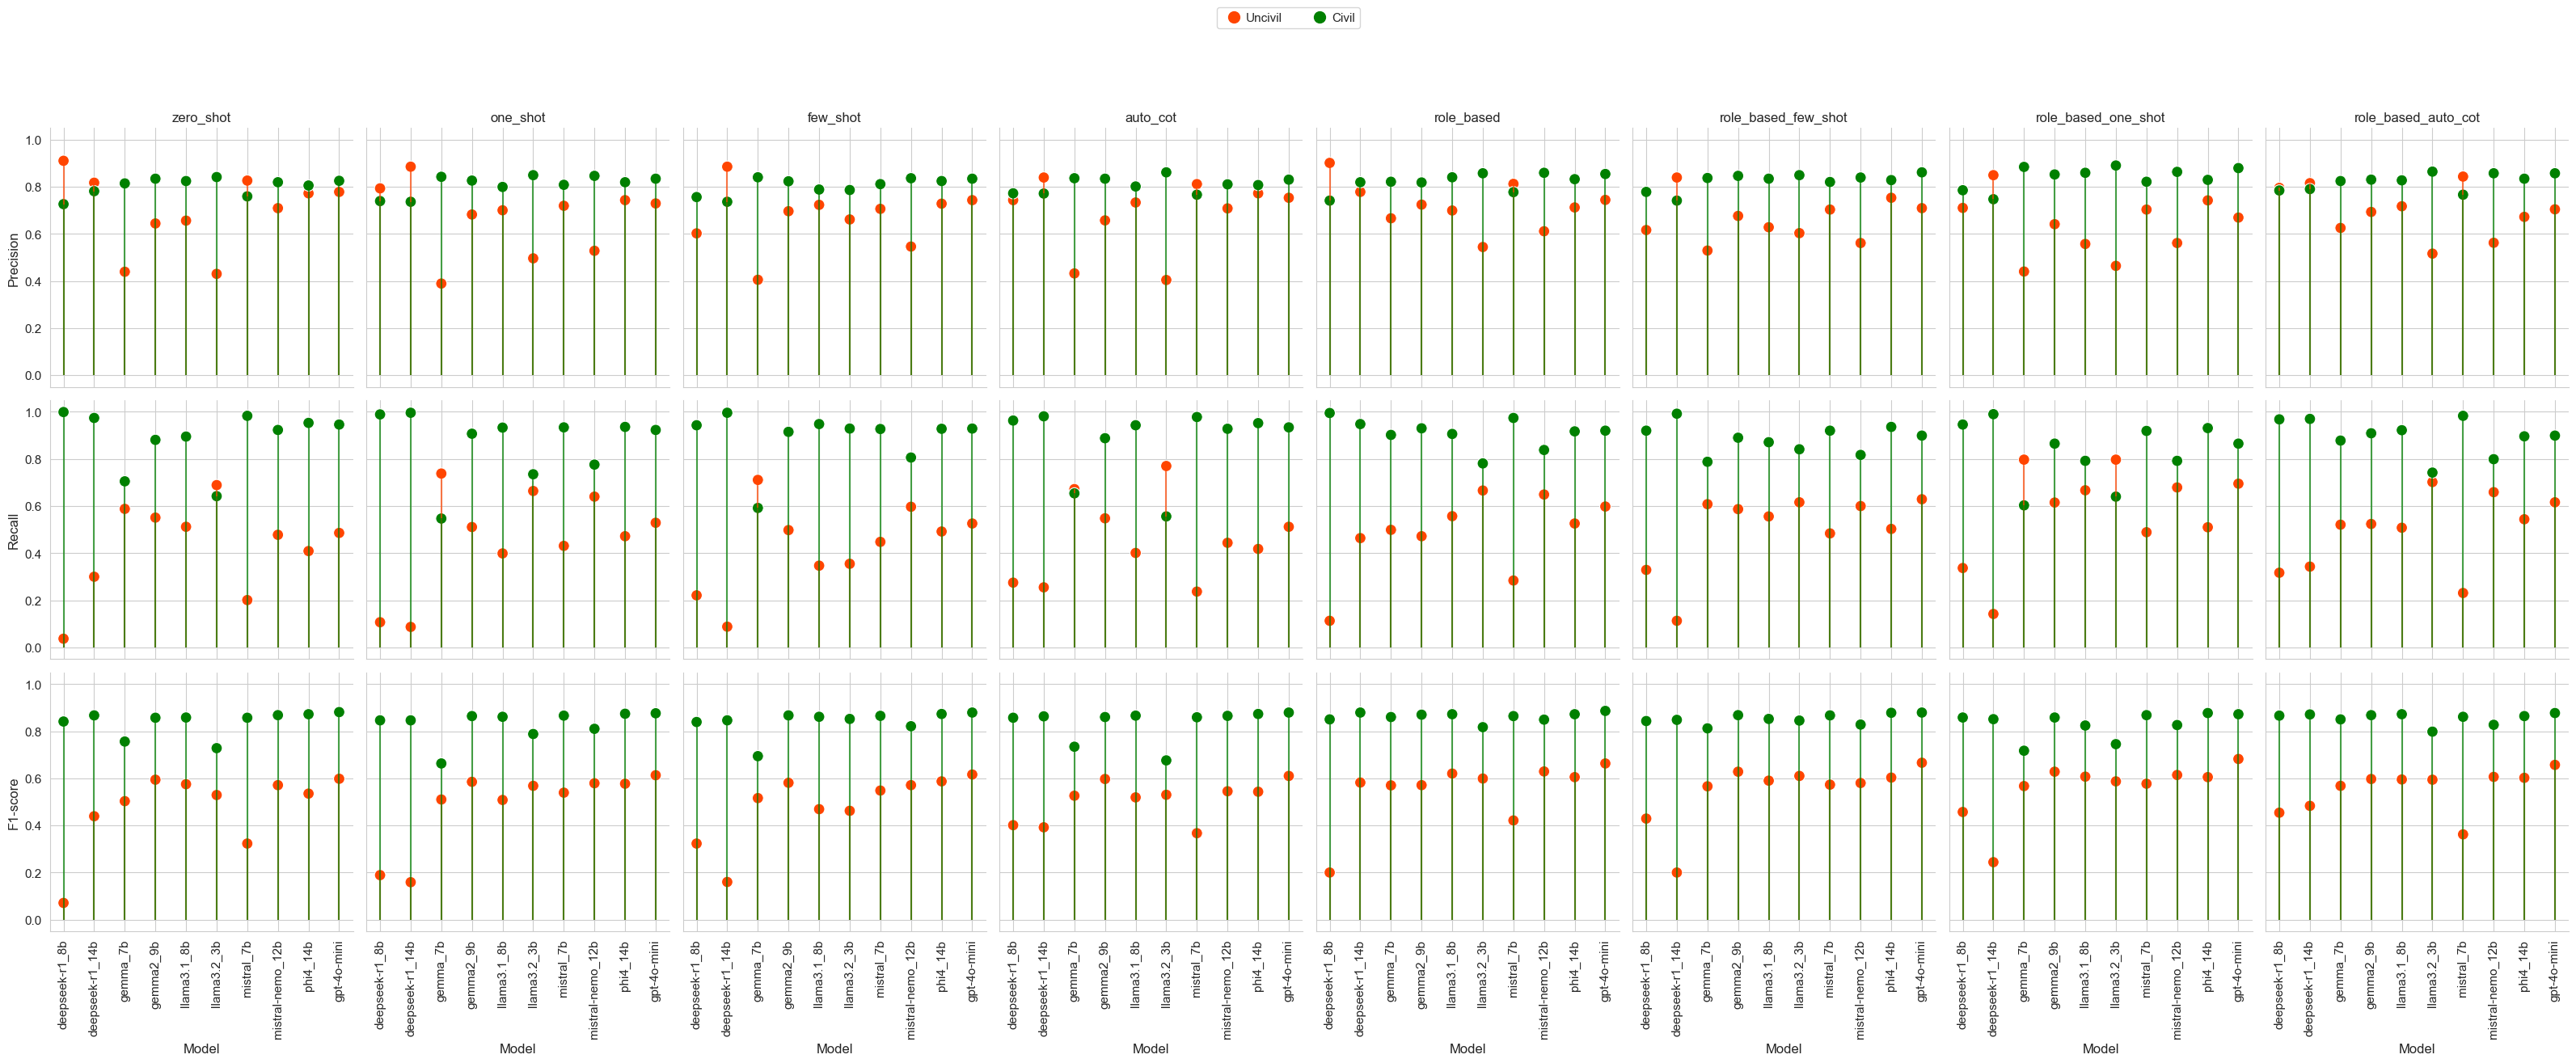

In [26]:
# Plot
uncivil["Class"] = "Uncivil"
civil["Class"] = "Civil"

civil = civil[["Model", "Class", "Strategy", "Precision", "Recall", "F1-score"]]
uncivil = uncivil[["Model", "Class", "Strategy", "Precision", "Recall", "F1-score"]]

df = pd.concat([uncivil, civil])
df_long = df.melt(id_vars=["Model", "Class", "Strategy"], var_name="Metric", value_name="Score")

plt.figure(figsize=(15, 15))
# sns.set_theme(style="whitegrid", font_scale=1.2)

# Ordena os modelos como no original
model_order = df["Model"].unique()

# FacetGrid para cada métrica
g = sns.FacetGrid(df_long, row='Metric', col="Strategy", sharey=True, sharex=True, height=4, aspect=1)
colors = {"Uncivil": "orangered", "Civil": "green"}

def lollipop(data, **kwargs):
    for _, row in data.iterrows():
        plt.vlines(row["Model"], ymin=0, ymax=row["Score"], color=colors[row["Class"]], alpha=0.7)
    sns.scatterplot(data=data, x="Model", y="Score", hue="Class", palette=colors, s=100, legend=False)

g.map_dataframe(lollipop)
g.set_xticklabels(model_order, rotation=90)
g.set_titles("")

for ax, col_value in zip(g.axes[0], df_long["Strategy"].unique()):
    ax.set_title(col_value)

g.set_xlabels("Model")

for ax, metric in zip(g.axes[:, 0], df_long["Metric"].unique()):
    ax.set_ylabel(metric)


#g.set_axis_labels("Model", "Score")

handles = [plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in colors.values()]
labels = list(colors.keys())
g.fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2, handletextpad=0.0001)

plt.tight_layout()

plt.show()

<Figure size 1200x1200 with 0 Axes>

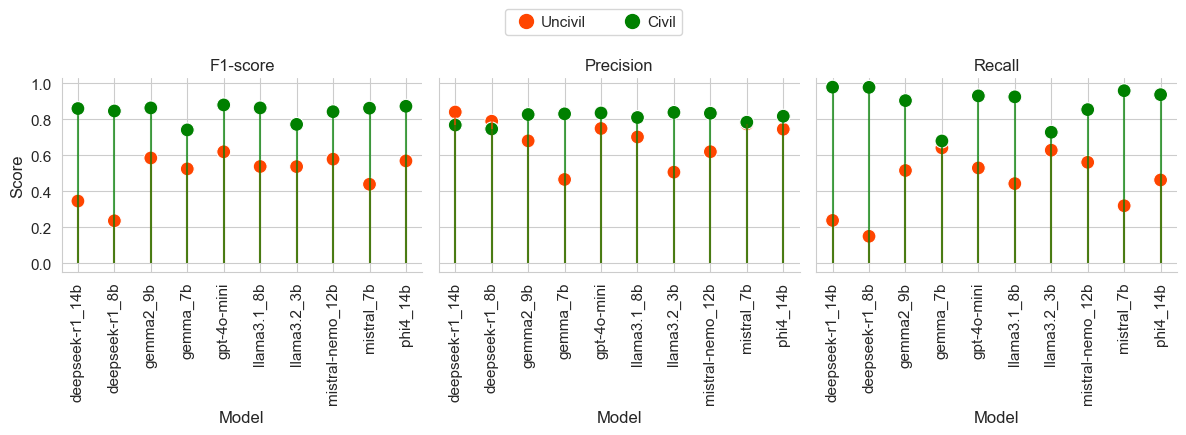

In [20]:
# Dados do dataset "uncivil"
uncivil_data = uncivil_sem_combinacoes.groupby('Model')[['F1-score', 'Precision', 'Recall']].mean().reset_index().copy()

# Dados do dataset "civil"
civil_data = civil_sem_combinacoes.groupby('Model')[['F1-score', 'Precision', 'Recall']].mean().reset_index().copy()

# Adicionando rótulos
uncivil_data["Class"] = "Uncivil"
civil_data["Class"] = "Civil"

# Unindo os dois dataframes e pivotando para long format
df = pd.concat([uncivil_data, civil_data ])
df_long = df.melt(id_vars=["Model", "Class"], var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(12, 12))
# sns.set_theme(style="whitegrid", font_scale=1.2)

# Ordena os modelos como no original
model_order = df["Model"].unique()

# FacetGrid para cada métrica
g = sns.FacetGrid(df_long, col="Metric", sharey=True, height=4, aspect=1)
colors = {"Uncivil": "orangered", "Civil": "green"}

def lollipop(data, **kwargs):
    for _, row in data.iterrows():
        plt.vlines(row["Model"], ymin=0, ymax=row["Score"], color=colors[row["Class"]], alpha=0.7)
    sns.scatterplot(data=data, x="Model", y="Score", hue="Class", palette=colors, s=100, legend=False)

g.map_dataframe(lollipop)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Model", "Score")

handles = [plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in colors.values()]
labels = list(colors.keys())
g.fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2, handletextpad=0.0001)

plt.tight_layout()


fig_path = results_path / 'figures'
os.makedirs(fig_path, exist_ok=True)
plt.savefig(fig_path / 'metrics_comparison.pdf', bbox_inches='tight', dpi=600)

plt.show()

In [5]:
uncivil.groupby('Model')[['F1-score', 'Precision', 'Recall']].mean()

,F1-score,Precision,Recall
Model,,,
deepseek-r1_14b,0.332375,0.838375,0.224000
deepseek-r1_8b,0.315500,0.758750,0.217000
gemma2_9b,0.597625,0.676625,0.538250
gemma_7b,0.540750,0.490625,0.641750
gpt-4o-mini,0.638125,0.728625,0.573875
llama3.1_8b,0.560375,0.676625,0.493375
llama3.2_3b,0.559875,0.514750,0.657375
mistral-nemo_12b,0.586875,0.598250,0.593250
mistral_7b,0.463750,0.765375,0.350625


In [6]:
civil.groupby('Model')[['F1-score', 'Precision', 'Recall']].mean()

,F1-score,Precision,Recall
Model,,,
deepseek-r1_14b,0.858875,0.765125,0.980875
deepseek-r1_8b,0.850000,0.760125,0.965375
gemma2_9b,0.864000,0.832875,0.898125
gemma_7b,0.760750,0.837250,0.708625
gpt-4o-mini,0.878625,0.846750,0.914375
llama3.1_8b,0.858250,0.821500,0.901250
llama3.2_3b,0.781125,0.849625,0.733250
mistral-nemo_12b,0.836750,0.841125,0.834875
mistral_7b,0.863375,0.791000,0.952250
